In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error


In [2]:
# links = pd.read_csv('ml-latest-small/links.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
# tags = pd.read_csv('ml-latest-small/tags.csv')

### Transforming the data
When we work with cosine similutude, we might assume that two users are the same, when actually they are not.
E.g. user1 really likes Die Hard and Transformers and rates them 5 stars each.
user2 hates both movies and rates them 1 star each. With cosine similutude we'd recognize them as the same. 
To prevent this we will arbitrarily deduce 2.4 from all ratings to have the scale roughly centered around 0. 
Now, user1 with 2.6 and user2 with -1.4 will be recognized as different.
We choose not to exactly center our ratings at 0 as we use this value to recognize non-rated movies in the pipeline.

In [3]:
ratings_recentered = ratings.copy()
ratings_recentered.rating = ratings_recentered.rating -2.4

### Split the data in a training and testing dataset and restructre both

In [4]:
train, test = train_test_split(ratings_recentered, random_state=42, test_size=.2)

piv_ratings = pd.pivot(data=train, index='userId', columns='movieId', values='rating')


### Impute missing values

In [5]:
imputer = SimpleImputer(strategy='constant',fill_value=0)
imp_ratings = pd.DataFrame(imputer.fit_transform(piv_ratings), index=piv_ratings.index, columns=piv_ratings.columns)
imp_ratings.head(10)


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.6,0.0,1.6,0.0,0.0,1.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.6,2.6,0.6,0.0,0.0,1.6,0.6,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create a similarity matrix
even when non rated movies are removed from calculating the acutal predictions, the similarites are determined with all of those non-ratings in place. Here, the similarity between users are calculated without taking these imputed values in account

In [6]:
def cosine_similarity_non_zero(data, user, user_to_compare):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    cosine_sim_pre = (
    pd.DataFrame({
        'user_1':data.loc[user,:],
        'user_2':data.loc[user_to_compare,:]
    })
        # remove all the movies that have not been rated (rating == 0)
        .query('user_1 != 0 & user_2 != 0')
        # apply cosine formula
        .assign(
            x = lambda x: x.user_1*x.user_1, 
            y = lambda x: x.user_2*x.user_2, 
            xy = lambda x: x.user_1*x.user_2, 
        )
        .agg({'x':'sum', 'y':'sum', 'xy':'sum'})
    )
    cosine_similarity = cosine_sim_pre.loc['xy'] / (cosine_sim_pre.loc['x'] * cosine_sim_pre.loc['y'])**0.5
    return cosine_similarity

# cos_sim = [[cosine_similarity_non_zero(imp_ratings, user, user_to_compare) for user_to_compare in imp_ratings.index] for user in imp_ratings.index]
# cos_sim_non_zeros = pd.DataFrame(cos_sim, columns=imp_ratings.index, index=imp_ratings.index)


In [7]:
# similarity = cos_sim_non_zeros.copy().fillna(0)
similarity = pd.DataFrame(cosine_similarity(imp_ratings), index=piv_ratings.index, columns=piv_ratings.index)
similarity

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.016551,-0.002646,0.113888,0.099863,0.101553,0.093216,0.126564,0.057639,-0.030074,...,0.081539,0.144640,0.118308,0.050357,0.101865,0.127099,0.157765,0.159147,0.096588,0.147767
2,0.016551,1.000000,0.000000,-0.015058,0.000000,0.008500,0.006059,0.018835,0.000000,0.069885,...,0.160586,0.012422,0.009986,0.000000,0.000000,0.018142,0.009033,0.051758,0.019976,0.079086
3,-0.002646,0.000000,1.000000,0.000000,-0.042130,-0.021424,0.000000,-0.044082,0.000000,0.000000,...,-0.038471,-0.035784,0.010125,0.000000,0.003621,-0.017394,-0.026021,-0.029470,0.000000,0.022568
4,0.113888,-0.015058,0.000000,1.000000,0.088176,0.059538,0.070618,0.008119,0.000000,0.022922,...,0.028909,0.060486,0.140838,0.025269,0.071695,0.123473,0.044248,0.015915,0.015265,0.047393
5,0.099863,0.000000,-0.042130,0.088176,1.000000,0.162273,0.043760,0.352105,0.000000,-0.025198,...,0.061311,0.258826,0.058508,0.125717,0.067981,0.075819,0.056622,0.044288,0.235713,0.042373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.127099,0.018142,-0.017394,0.123473,0.075819,0.062641,0.100459,0.058997,0.051355,0.009673,...,0.146206,0.061128,0.202070,0.063887,0.109443,1.000000,0.091585,0.158960,0.050798,0.158323
607,0.157765,0.009033,-0.026021,0.044248,0.056622,0.140553,0.141384,0.160631,0.007680,-0.033905,...,0.107855,0.157953,0.097071,0.101178,0.070602,0.091585,1.000000,0.127606,0.085928,0.092377
608,0.159147,0.051758,-0.029470,0.015915,0.044288,0.031521,0.127984,0.103539,0.060577,0.009001,...,0.139008,0.075330,0.105175,0.038628,0.080762,0.158960,0.127606,1.000000,0.083267,0.222410


### Build a recommender function

In [8]:
def predict_rating(user_id,movie_id):
    '''Predicts the rating a specific user (user_id) would give a specific movie.
     '''
    try:
        # find the ratings of the movie and the similarities to the user
        weighted_rating = (
            pd.DataFrame({'ratings': imp_ratings[movie_id],
            'similarity': similarity[user_id]})
            .query('ratings !=  0') # filter out the rating of everyone who did not actually rate (that includes the user themselves)
        )

        # redistributing weights - all positive & starting at 0
        weighted_rating.similarity = weighted_rating.similarity + abs(min(weighted_rating.similarity))
        weighted_rating.similarity = weighted_rating.similarity - (min(weighted_rating.similarity))
        #make sure all similarities to users in the prediction add up to 1
        if len(weighted_rating.similarity)>1 and sum(weighted_rating.similarity)!=0:
            weighted_rating.similarity = (
                weighted_rating.similarity /sum(weighted_rating.similarity)
                )
        elif sum(weighted_rating.similarity)==0:
            # In this case all users how voted for this movie have quite different preferences than the user we are looking for
            # As such their combined weight will be set equal to 0.5 to reduce the impact of ratings of very different users
            weighted_rating.similarity = 1 / (len(weighted_rating.similarity)/2)
        else: 
            print('There is a problem with the similarities!')

        weighted_rating = (weighted_rating   
            .assign(weighted_ratings = lambda x: x.ratings * x.similarity) # weight the food and similarities
            .agg({
            'weighted_ratings':'sum', 
            'similarity':'sum'})
        )
        
        return (weighted_rating[0]/weighted_rating[1]) + 2.4 # Return to the original scale
   
    # in some cases a movie in the test dataset has not been rated by another user or 
    # all other ratings of the movie are also in the test dataset
    # In these cases we cannot predict the rating
    except KeyError:        
        return 2.4
    

predict_rating(499,38304)

4.666666666666666

In [9]:
### Code for testing. Is not part of the pipeline
 
user_id = 153			
movie_id = 63082

weighted_rating = (
    pd.DataFrame({'ratings': imp_ratings[movie_id],
    'similarity': similarity[user_id]})
    .query('ratings !=  0') # filter out the rating of everyone who did not actually rate (that includes the user themselves)
)

# print(weighted_rating)
# print(sum(weighted_rating.similarity))

# redistributing ratings - all positive & starting at 0
weighted_rating.similarity = weighted_rating.similarity + abs(min(weighted_rating.similarity))
weighted_rating.similarity = weighted_rating.similarity - (min(weighted_rating.similarity))
#make sure all similarities to users in the prediction add up to 1
if len(weighted_rating.similarity)>1 and sum(weighted_rating.similarity)!=0:
    print('d')
    weighted_rating.similarity = (
    weighted_rating.similarity /sum(weighted_rating.similarity)
    )
elif sum(weighted_rating.similarity)==0:
    print('lksd')
    weighted_rating.similarity = 1 / len(weighted_rating.similarity)
else: 
    print('hjds')
    # for some movies only one rating in available. Here we have to assume that the rated user and the user to predict are quite similar 
    weighted_rating.similarity = weighted_rating.similarity / sum(weighted_rating.similarity)

# print(weighted_rating)
# print(sum(weighted_rating.similarity))

weighted_rating = (weighted_rating   
    .assign(weighted_ratings = lambda x: x.ratings * x.similarity) # weight the food and similarities
    .agg({
    'weighted_ratings':'sum', 
    'similarity':'sum'})
)

# print(weighted_rating)
print(weighted_rating[0]/weighted_rating[1] +2.4)

d
3.8339565223771634


In [12]:
test['predicted_rating'] = test.apply(lambda row: predict_rating(row['userId'], row['movieId']), axis=1)
test.rating = test.rating + 2.4 # rescale to original star scale
test

C:\Users\Angelika\AppData\Local\Temp/ipykernel_13128/3076681095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_rating'] = test.apply(lambda row: predict_rating(row['userId'], row['movieId']), axis=1)
C:\Users\Angelika\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,userId,movieId,rating,timestamp,predicted_rating
67037,432,77866,4.5,1335139641,3.192479
42175,288,474,3.0,978465565,3.729680
93850,599,4351,3.0,1498524542,3.278163
6187,42,2987,4.0,996262677,3.656770
12229,75,1610,4.0,1158989841,3.853965
...,...,...,...,...,...
57416,380,5048,2.0,1494268065,3.011874
67290,434,54272,3.5,1270606860,3.632557
33423,226,5989,4.5,1162428551,3.969010
98552,607,1320,3.0,963080497,3.125575


In [16]:
print(f'number of observations in the test dataset: {len(test)}')
print(f'number of unpredicted observations: {len(test.query("predicted_rating==2.4"))}')

number of observations in the test dataset: 20168
number of unpredicted observations: 813


In [17]:
print(f'number of NaN (=errors) in the predictions: {len(test[test.predicted_rating.isna()])}')

number of NaN (=errors) in the predictions: 0


In [18]:
print(f'The mean absolute error is {mean_absolute_error(test.rating,test.predicted_rating)}')

The mean absolute error is 0.7604963825647991


## Effect of changes to the code on the mean absolute error
1. When imputing with 0 the MAE is around 3. 
2. When imputing with 2.5 the MAE is around 1.3. 
3. Removing not-real ratings (=imputed values) from the prediction step reduced MAE to 0.85. Imputed values (0) are still used to calculate similarities between users
4. transformed the data to roughly center around 0. MAE = 0.76.
Not a huge improvment considering that we also now have the imputing value closer in the middle of our scaling range - However, when testing this (no transformation of data, imputing value=2.4) MAE was 0.86. So transformation does help
5. Determined consine similarity without taking imputed values in account. Computing the similarities this way takes ages and does help with accuracy. MAE = 0.77

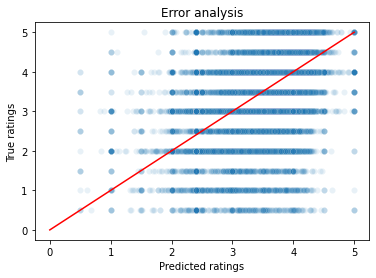

In [20]:
plt.title('Error analysis')
plt.xlabel('Predicted ratings')
plt.ylabel('True ratings')
sns.lineplot(x=[0,5], y=[0,5], color='red')
sns.scatterplot(x=test.predicted_rating, y=test.rating, alpha=0.1)
plt.show()

<AxesSubplot:xlabel='predicted_rating', ylabel='Count'>

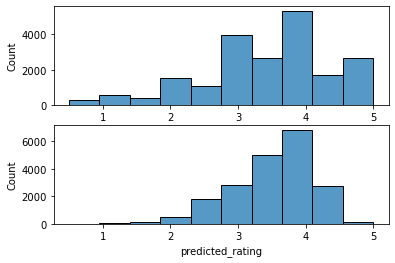

In [21]:
plt.subplot(211)
sns.histplot(data=test, x='rating', bins=10)
plt.subplot(212)
sns.histplot(data=test, x='predicted_rating', bins=10)

### Recommender
The results is not particularly good. But we can still use this to build a recommender. 

In [22]:
def find_movie_names(ids):
    '''Takes a movieId or a list of movieIds and returns a list with its/their corresponding movie titles.'''
    movie_titles = list()
    if isinstance(ids,list):
        for el in ids:
            movie_titles.append(find_single_movie_name(el))
    elif (isinstance(ids,str) and ids.isnumeric()) or isinstance(ids, int) or isinstance(ids, float):
        movie_titles.append(find_single_movie_name(ids))
    else:
        print(f'Data type of input ({ids}) not valid.')
    return movie_titles

def find_single_movie_name(id):
    '''Takes a single movieId and returns the corresponding title.'''
    return movies.query(f'movieId=={id}').title.values[0]


def rec_iter3(user_id):
    '''Returns movie recommendations for the given user. 
    The movies are ordered by likelihood that the user will like them with the most best rated on top. 
    Movies that the user has already seen are excluded.

    To calculate a score the similarities are adjusted but the imputed ratings are included in the predictions.
    However, this computation is much faster than the alternative more accurate one.
    '''
    # compute the weights for the inputed user
    weights = similarity.query('userId!=@user_id')[user_id] / sum(similarity.query('userId!=@user_id')[user_id])
    
    ## remove users who didn't rate movies

    #redistributing weights
    weights = weights + abs(min(weights))
    weights = weights - min(weights)
    if len(weights)>1 and sum(weights)!=0:
        weights=weights/sum(weights)
    elif sum(weights)==0:
        weights = weights/len(weights)

    # select movies that the inputed user has not seen
    unseen_movies = imp_ratings.loc[imp_ratings.index!=user_id, imp_ratings.loc[user_id,:]==0]
    

    # multiply the unseen movies and the weights
    weighted_averages = unseen_movies.T.dot(weights)

    # get the top n movies 
    recommendations = pd.DataFrame(weighted_averages.sort_values(ascending=False))
    recommendations.insert(0, 'movie', find_movie_names(list(recommendations.index)))
    return recommendations

rec_iter3(80)

,movie,0
movieId,,
356,Forrest Gump (1994),0.912949
296,Pulp Fiction (1994),0.896036
2571,"Matrix, The (1999)",0.813682
2959,Fight Club (1999),0.722951
260,Star Wars: Episode IV - A New Hope (1977),0.660231
...,...,...
1499,Anaconda (1997),-0.019474
1760,Spice World (1997),-0.020137
8666,Catwoman (2004),-0.023045


In [23]:
train.groupby(by='movieId').userId.aggregate('count').sort_values(ascending=False).head(10)

movieId
356     276
318     257
296     256
593     226
2571    214
260     194
110     189
480     185
589     182
527     174
Name: userId, dtype: int64

The highest ranked recommendation for the random user 80 are all within the 10 movies with the highest rating counts. As the imputed ratings are not excluded from the analysis having many rateings increases the predicted rating much more than anything else. 
To achieve a personalized recommendation for every user we have to remove the imputed ratings from our prediction algorithm. Unfortunately, this is much computationally heavier.

In [24]:
def better_recommender(user_id):
    '''Returns movie recommendations for a given user.
    The movies are ordered by likelihood that the user will like them with the most best rated on top. 
    Movies that the user has already seen are excluded.

    This version should produce more accurate results 9and the ratings are acutally to scale, but it takes significantly longer to compute.
    '''
    recommendations = [['movieId','rating']]
    for movie_id in imp_ratings.columns:
        recommendations.append([movie_id,predict_rating(user_id,movie_id)])
    recommendations = pd.DataFrame(recommendations[1:], columns=recommendations[0]).sort_values('rating',ascending=False)
    # recommendations.rating = recommendations.rating + 2.4 # scaling ratings back to the 5 star system

    # movies seen by user
    unseen_movies = [movie for movie in imp_ratings.columns if imp_ratings.loc[user_id,movie]==0]
    
    recommendations = recommendations.query(f'movieId in {unseen_movies}')
    recommendations.insert(1,'movie', find_movie_names(list(recommendations.movieId)))
    return recommendations

better_recommender(80)

,movieId,movie,rating
8463,147328,The Adventures of Sherlock Holmes and Dr. Wats...,5.0
7312,92494,Dylan Moran: Monster (2004),5.0
7470,96832,Holy Motors (2012),5.0
3073,4298,Rififi (Du rififi chez les hommes) (1955),5.0
5240,26587,"Decalogue, The (Dekalog) (1989)",5.0
...,...,...,...
7010,82095,Skyline (2010),0.5
7764,107013,"Christmas Carol, A (1977)",0.5
8430,144352,Unforgiven (2013),0.5
7320,92681,Journey 2: The Mysterious Island (2012),0.5


In [27]:
pred_80 = better_recommender(80)
real_80 = ratings.query('userId == 80').sort_values('rating', ascending =
False)

In [39]:
pred_80.query(f'movieId in {list(real_80.query("rating>4").movieId)}')

,movieId,movie,rating
2158,2959,Fight Club (1999),4.319163
1883,2571,"Matrix, The (1999)",4.282954
2386,3275,"Boondock Saints, The (2000)",4.216876
6815,74458,Shutter Island (2010),4.097549
3500,4995,"Beautiful Mind, A (2001)",4.078180
3475,4963,Ocean's Eleven (2001),3.988547
3695,5418,"Bourne Identity, The (2002)",3.965141
4401,6874,Kill Bill: Vol. 1 (2003),3.921784
6955,80489,"Town, The (2010)",3.916978
6055,51662,300 (2007),3.851493
